<a href="https://colab.research.google.com/github/YoishD/Data-Science-B7/blob/main/YeshDakpU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

I have no clue about any of this data aside from the fact that adeline penguins are rather average for penguins. I mainly chose this data because it is Mr.A's data which means I don't have to mess with converting it into a data frame, and that I already know that it should work well with majority of the models I know. I also really like animals so thats another reason.

My main questions was orginally going to be how does the different islands effect body mass of the penguins of the same species, but Mr.A said I should only really have one category. So my new question is now: How will the different species effect the body mass of the penguins and what degree.

In [2]:
url_p = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/penguins.csv'
penguin = pd.read_csv(url_p)


pe_data = penguin.query("body_mass != 'NaN'")
p_data = pe_data.dropna()

p_data['species'] = p_data['species'].astype('category')

#This should drop all of my data that is not their

del p_data['island']
del p_data['bill_length']
del p_data['bill_depth']
del p_data['flipper_length']
del p_data['sex']
del p_data['year']
#I can also just use query and delete all the unused ones but this works for simplicitiy sake

spe_idx = p_data.species.cat.codes.values
spe_codes = p_data.species.cat.categories
spe_coords = {"spe": spe_codes}

<ipython-input-2-3f378e173d44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_data['species'] = p_data['species'].astype('category')


In [ ]:
p_data

,species,body_mass
0,Adelie,3.750
1,Adelie,3.800
2,Adelie,3.250
4,Adelie,3.450
5,Adelie,3.650
...,...,...
339,Chinstrap,4.000
340,Chinstrap,3.400
341,Chinstrap,3.775
342,Chinstrap,4.100


from matplotlib import pyplot as plt
p_data['body_mass'].plot(kind='hist', bins=20, title='body_mass')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
p_data['body_mass'].plot(kind='line', figsize=(8, 4), title='body_mass')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
penguin #my orginal data that I was comparing to P_data to ensure that I truly did remove all data that I didn't need

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


<Axes: xlabel='species', ylabel='body_mass'>

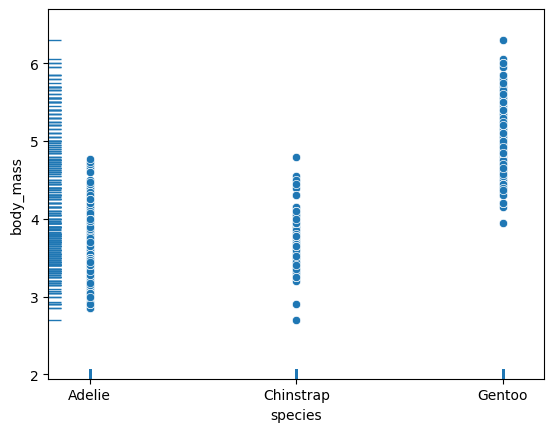

In [ ]:
sns.scatterplot(data=p_data, x="species", y="body_mass")
sns.rugplot(data=p_data, x="species", y="body_mass")

<Axes: xlabel='body_mass', ylabel='Density'>

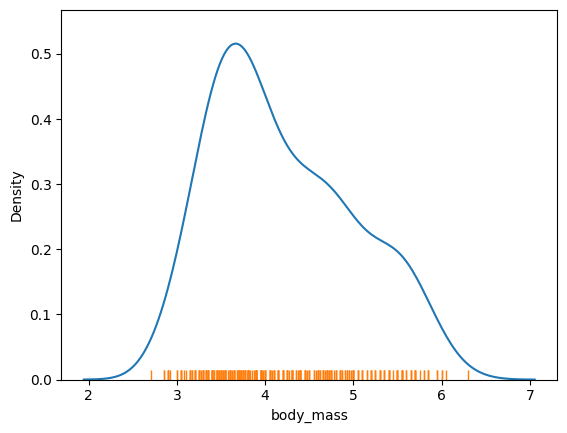

In [ ]:
sns.kdeplot(data=p_data, x="body_mass")
sns.rugplot(data=p_data, x="body_mass")

I went through seaborn API to try to find some graphs in order to figure out my priors and distribution as my knowledge of the body mass of penguins is surpisingly low. It seems that we have a average of around 3.4-3.8, judging based of the density indicator, and we have a right skew. The graph is actually kind of bumpy which might be weird to try and model.I can see that my body mass has two points of high frequency, 3.7 and 4.7. So I should try to account for that

Im right now thinking about cauchy,gumbel, StudentT, and moyal. As all of these are just continous distributions with the probability of having a right skew. However none of them can accuratley account for the two high frequency point so i am also leaning towards logitnormal.

After looking at the api, Gumbel drops off to fast and logit doesnt work like how I though it did as it drops off after x=1, so Im left with just StudentT,and Moyal,



In [10]:
with pm.Model(coords = spe_coords) as species_model:
    # HyperParameters for m
    u_p = pm.StudentT('u_p',mu = 4.4 ,nu = 1,sigma = 1,)

    l_p = pm.StudentT('l_p',mu = 3.7 ,nu = 1,sigma = 1)

    # priors for Penguins
    μ = pm.Uniform('μ', upper = u_p, lower= l_p, dims="spe")
    σ = pm.Beta('σ', mu = .5, sigma = .02 ,dims = "spe")

    #likelihood
    y = pm.Moyal('gs',
                    mu = μ[spe_idx],
                    sigma = σ[spe_idx],
                    observed = p_data.body_mass.values)


    idata_species_bm = pm.sample(target_accept = 0.95) #I know I dont need the target accept, but Mr.A has it in his, and it is supposed to desvrease divergences so it should be fine.

/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:763: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Output()

Output()

array([[<Axes: title={'center': 'l_p'}>, <Axes: title={'center': 'l_p'}>],
       [<Axes: title={'center': 'u_p'}>, <Axes: title={'center': 'u_p'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

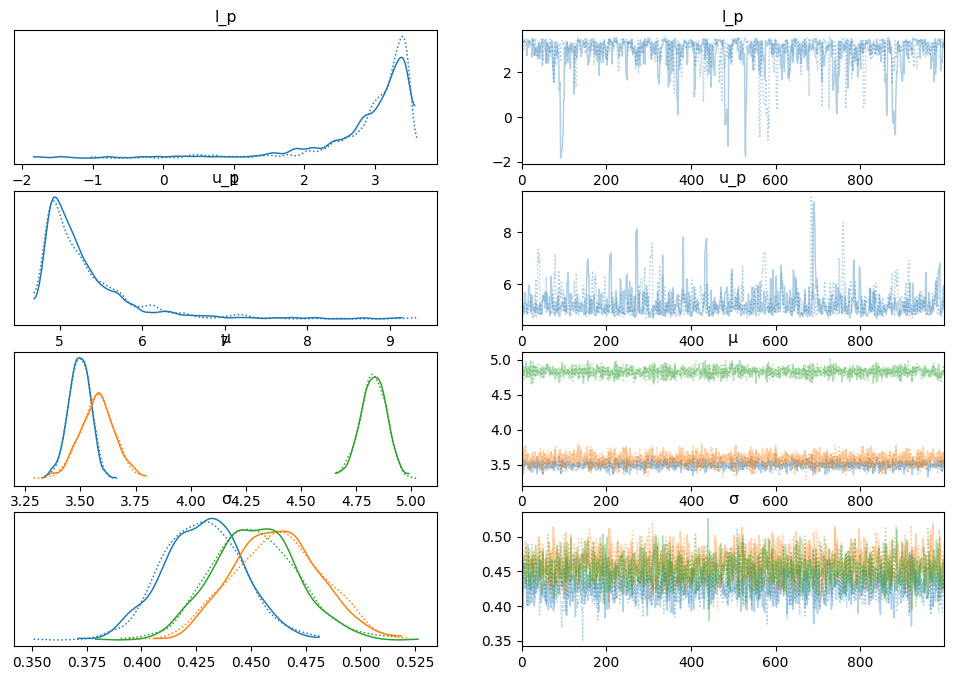

In [11]:
az.rhat(idata_species_bm)
az.plot_trace(idata_species_bm)

Output()

<Axes: xlabel='gs'>

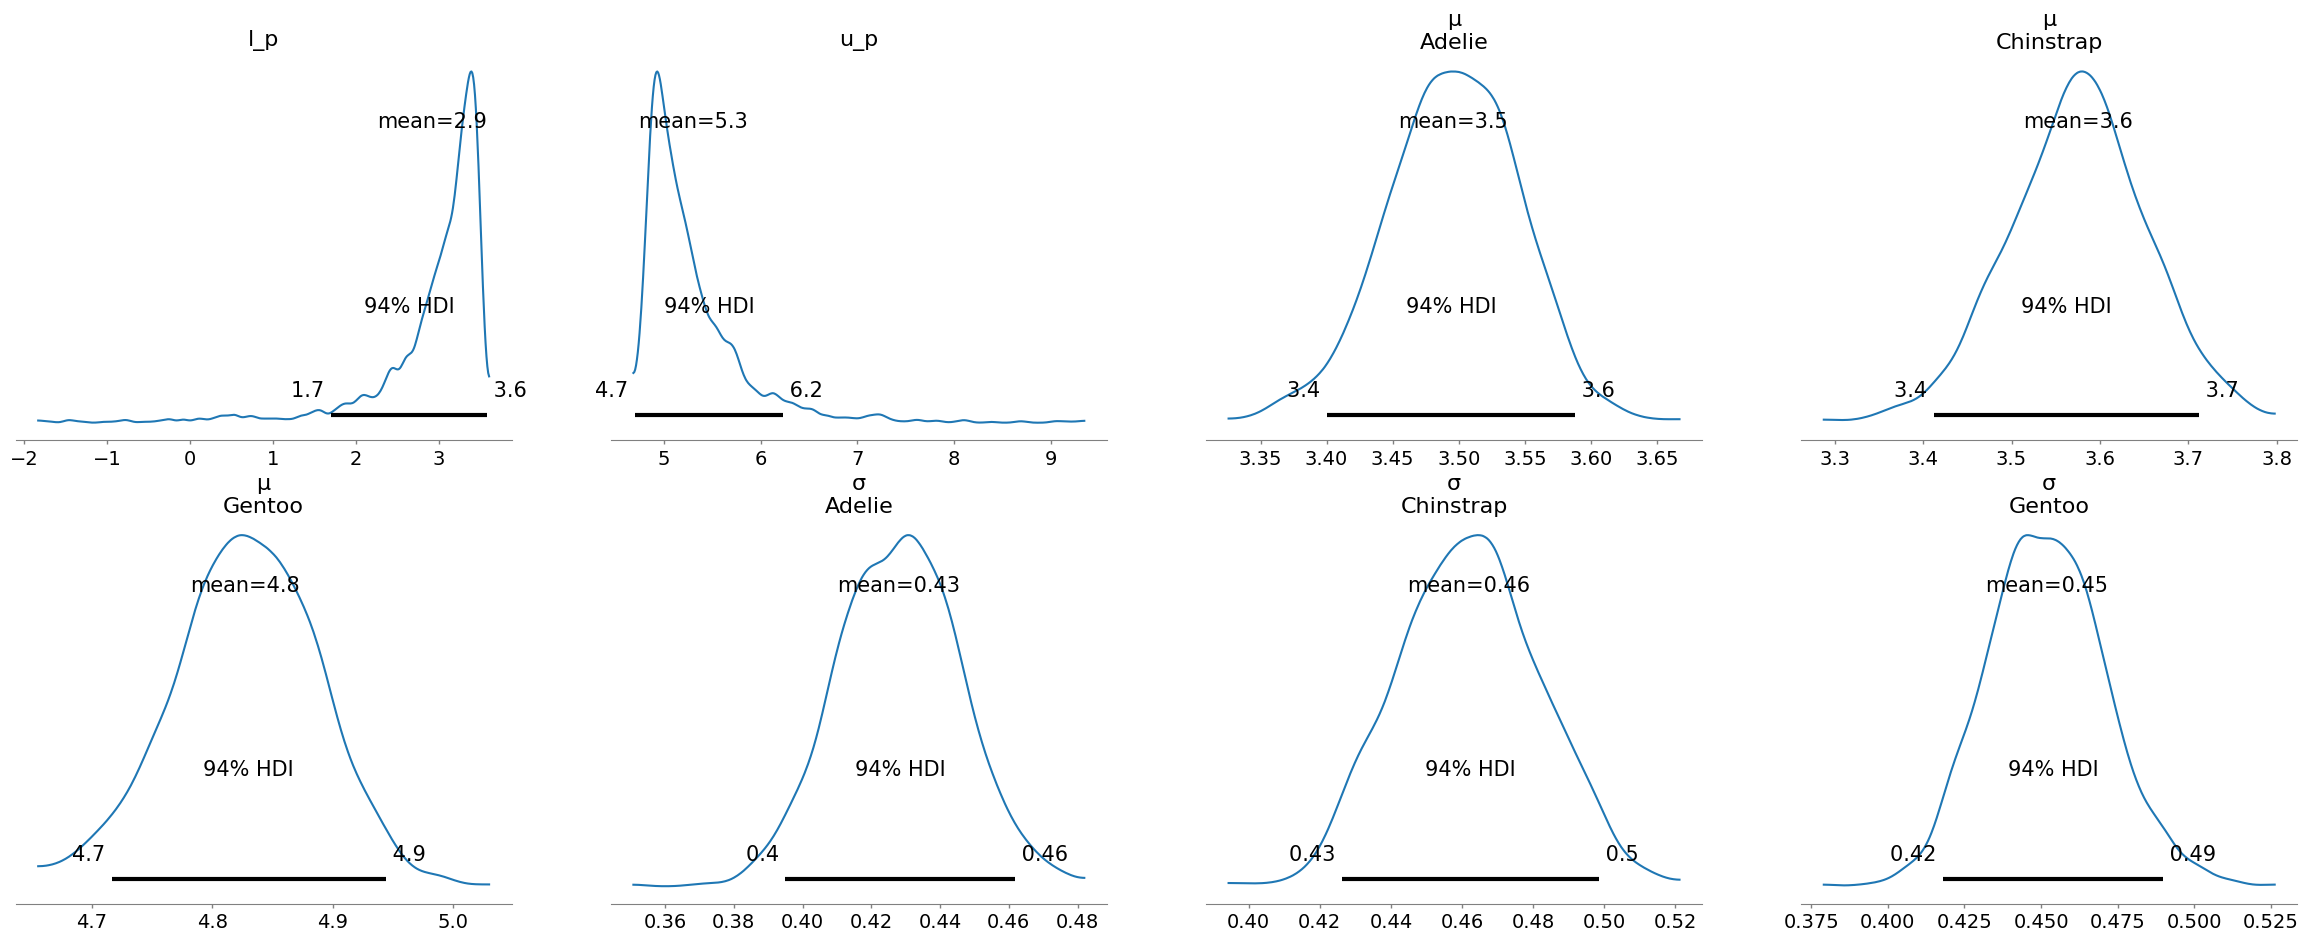

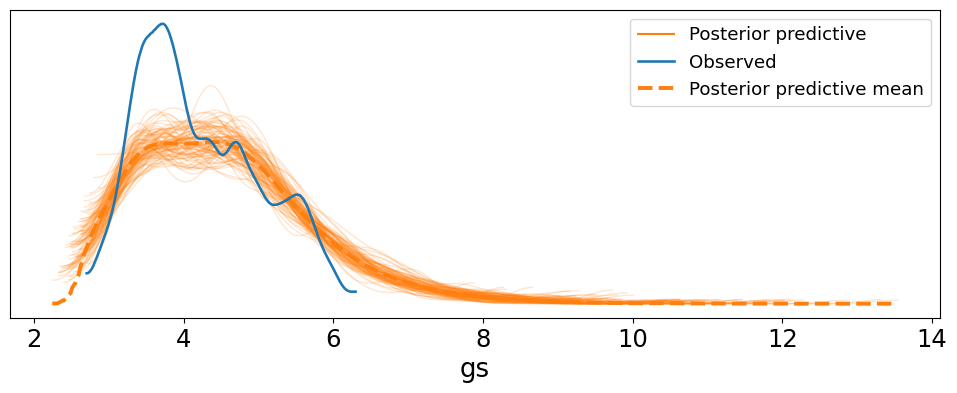

In [12]:
az.plot_posterior(idata_species_bm)
pm.sample_posterior_predictive(idata_species_bm, model=species_model, extend_inferencedata=True)
az.plot_ppc(idata_species_bm, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

So very clearly my model isn't accurate. I can see where we have two clear bumps so my choice for using Moyal to model that bumpy nature of my actualy data isn't wasn't completly off, I think I just underestimated Moyal's "bumpyness". I still want to see how my ridge plot will interact with this incorrect model, so I'll still do that but after I mostly leaning on trying Gumbel or Gamma in order to replicate the skewness and the overall shape and just focusing on ignoring the bumpyness for now. The bumpyness is most likely caused by how certain species just have more data collected so the bodymass range which that species falls under just has more data for that, and I'm not quite sure how I would account for this.

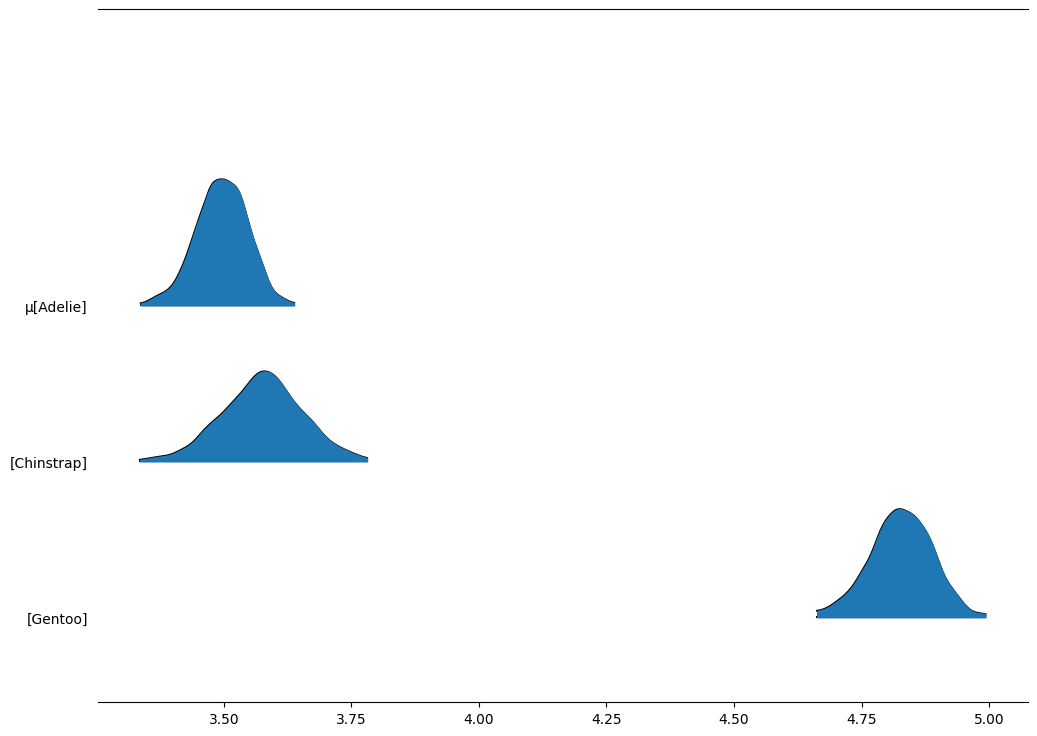

In [13]:
xes = az.plot_forest(idata_species_bm, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

From this we can see that by far Gentoo penguins have a higher body mass, then  Chinstrap, which is closely followed by Adelie penguins.

In [ ]:
with pm.Model(coords = spe_coords) as species_model:
    # HyperParameters for m
    u_p = pm.StudentT('u_p',mu = 5 ,nu = 1,sigma = 1,)

    l_p = pm.StudentT('l_p',mu = 4 ,nu = 1,sigma = 1)

    #I know that my mu for studentT should be larger than 2 but also show be close to it but im unsure by how much so Im just gonna use a hyper prior.
    b_p = pm.Uniform('b_p', upper = 2.2, lower= 2)
    #This number seems really specific and thats cuz it is. I have tried manually plugging in 1.7,1.8,and 1.9, where each one giving divergences with
    #1.9 being the biggest offender.

    # priors for Penguins
    μ = pm.Uniform('μ', upper = u_p, lower= l_p, dims="spe") #This is just my mean again, however I did make my range more on the larger side as I felt as I had underestimated the first time
    b = pm.StudentT('b',mu = b_p ,nu = 1,sigma = 1,dims = "spe") #Looking at the api, I know I want my beta to be near2,
#as the api showcases a Gumbel, with a beta of 2 and mu of 4, and it just barely doesn't include 0, and since my mu or locoation param is in that range I'm basing this value around that

    #likelihood
    y = pm.Gumbel('gs',
                    mu = μ[spe_idx],
                    beta = b[spe_idx],
                    observed = p_data.body_mass.values)


    idata_species_bm = pm.sample(target_accept = 0.95)

Output()

Output()

array([[<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'l_p'}>, <Axes: title={'center': 'l_p'}>],
       [<Axes: title={'center': 'u_p'}>, <Axes: title={'center': 'u_p'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>]],
      dtype=object)

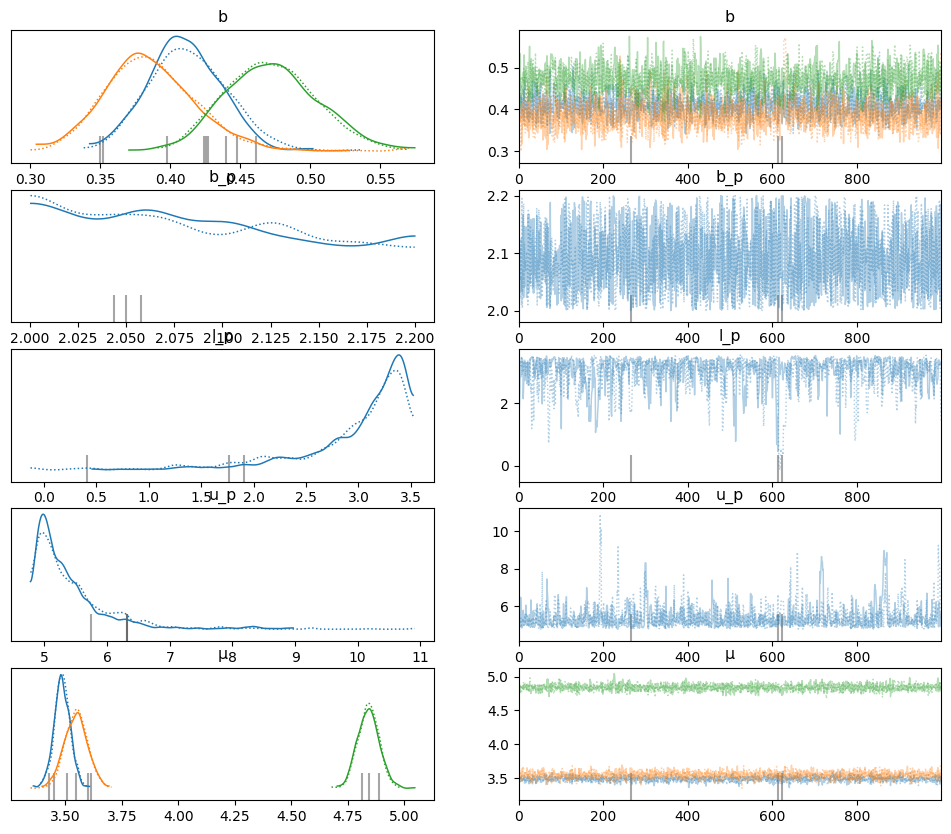

In [42]:
az.rhat(idata_species_bm)
az.plot_trace(idata_species_bm)

Output()

<Axes: xlabel='gs'>

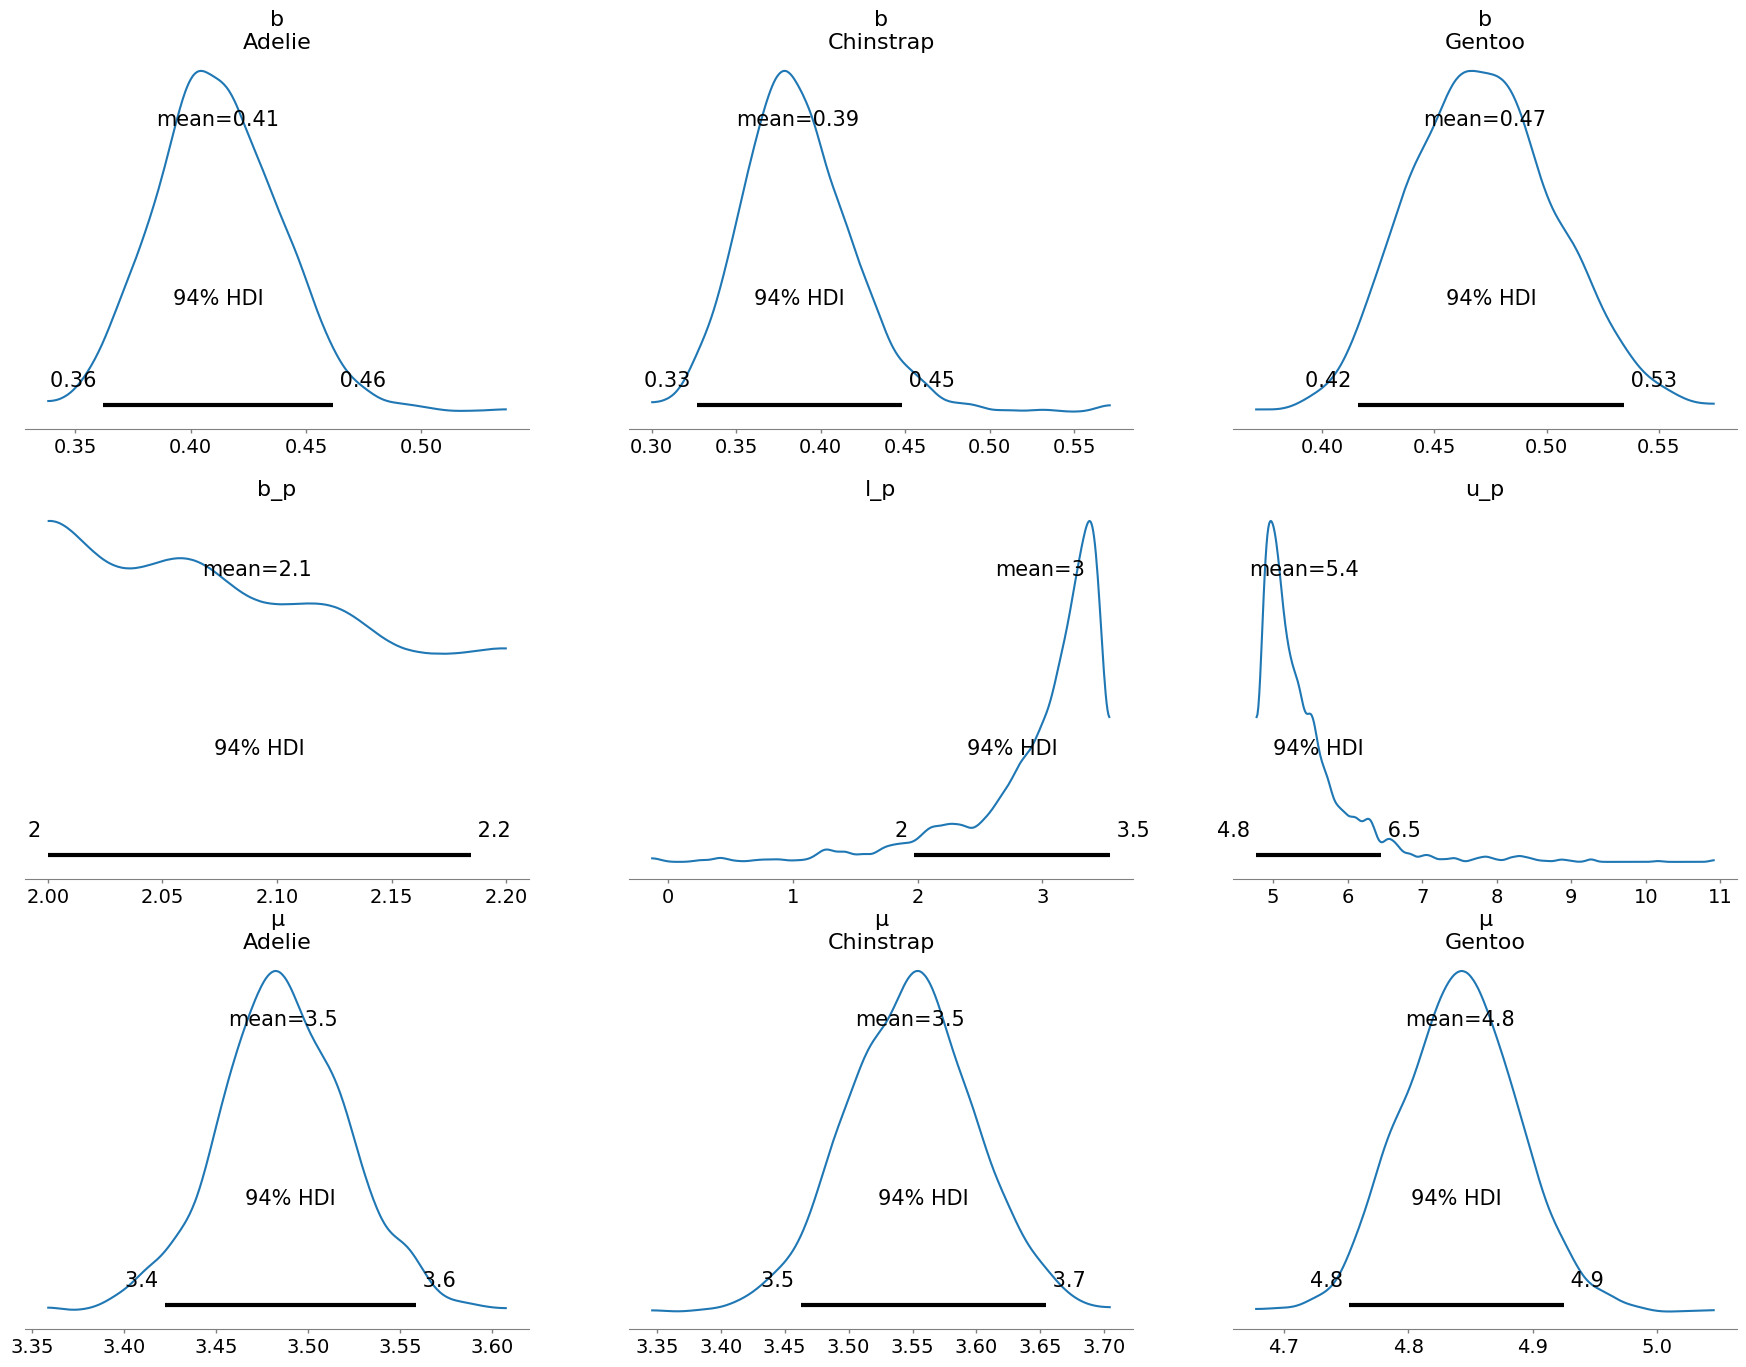

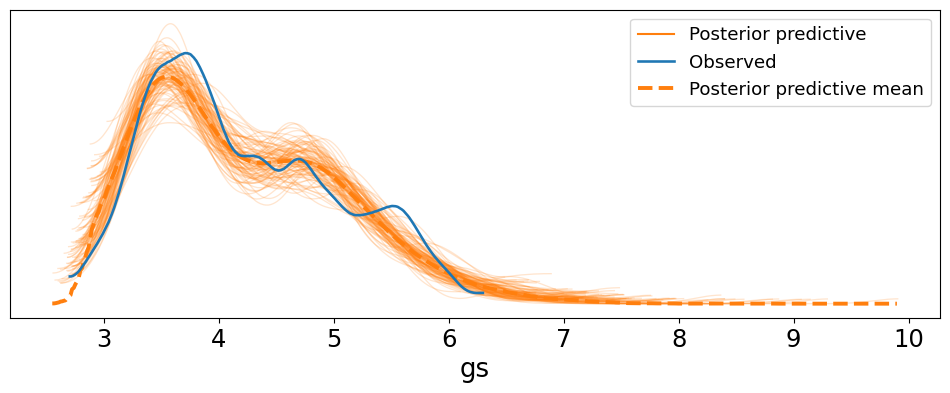

In [43]:
az.plot_posterior(idata_species_bm)
pm.sample_posterior_predictive(idata_species_bm, model=species_model, extend_inferencedata=True)
az.plot_ppc(idata_species_bm, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

So, Gumbel was actually able to replicate the bumpynes,for the most part. The observed is obviously significantly more bumpy, and also quite a bit larger, esp near the peak,where it is very clear that the ppm is underestimating. However it is able to model it somewhat accuratley and works, so I count that as a win.

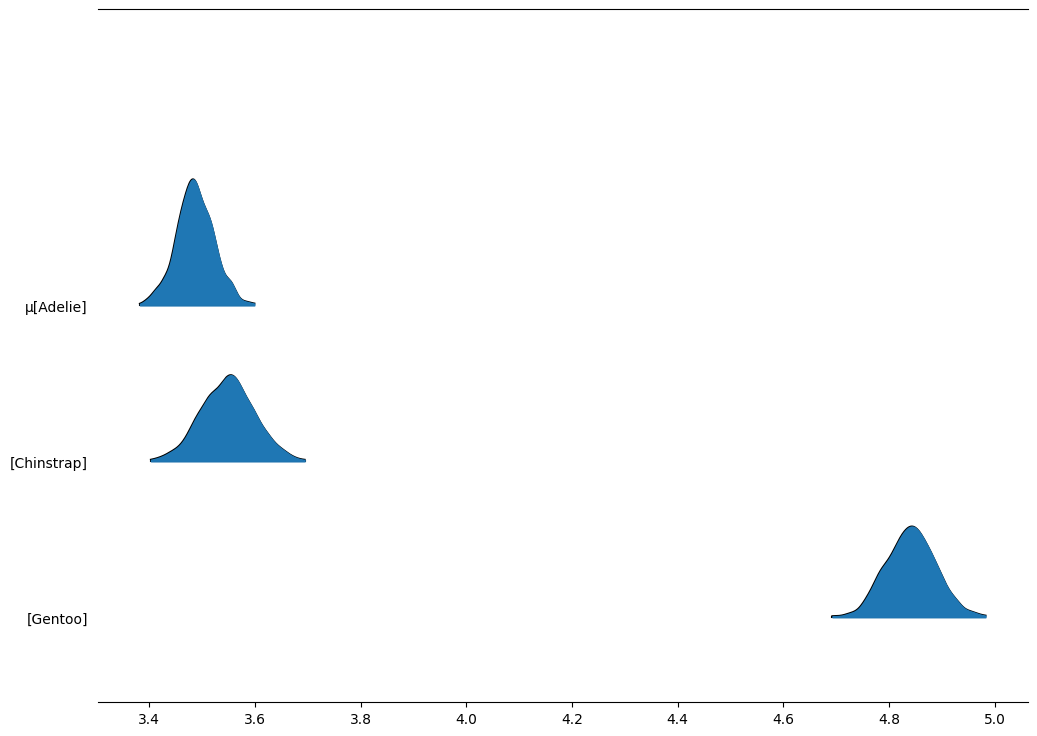

In [44]:
xes = az.plot_forest(idata_species_bm, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

Overall no new info, Gentoo is still the largest and Adeline are the smallest. However I will say that that this graph, showcases the body masses as more concentrated around their means.

In regards to my question, I can confidently say that yes, penguin species definitely has an affect on body mass to some degree, as we can clearly see the gap between Gentoo and other penguin species. I will also say that this relationship is clearly different as both Chinstrap and Adeline penguins actually fall under eachothers ranges, showcasing how their species has very little effect on eachothers body mass, in comparison to eachother.